<a href="https://colab.research.google.com/github/edwin-19/pytorch_nlp/blob/master/Text_Classification_Torch_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics
!pip install scikit-plot

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchtext
from torchtext.datasets import AG_NEWS
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data.dataset import random_split

from torchmetrics.functional import accuracy

from tqdm.notebook import tqdm
import time
import numpy as np

from sklearn.metrics import classification_report, matthews_corrcoef
from scikitplot.metrics import plot_confusion_matrix, plot_precision_recall_curve

In [3]:
# Build device
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
lr = 5
batch_size = 64
epochs = 20

# Prepare dataset
- Lets download and prepare a dataset for nlp data
- Get tokenizer and basic pipeline ready

In [4]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train') 

In [5]:
text = next(train_iter)[1]
tokenized_text = tokenizer(text)
tokenized_text[:5], text

(['wall', 'st', '.', 'bears', 'claw'],
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [6]:
# Function to get next token
def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

In [7]:
vocab = torchtext.vocab.build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>'])
vocab.set_default_index(vocab["<unk>"])

In [8]:
# Works similar to a tokenizer from tf
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

# Prepare dataloader
- Create a dataset and dataloader for training

In [9]:
def collate_batch(batch):
  label_list, text_list, offsets = [], [], [0]

  for (_label, _text) in batch:
    label_list.append(int(_label) - 1)
    processed_text = torch.tensor(vocab(tokenizer(_text)), dtype=torch.int64)
    text_list.append(processed_text)
    offsets.append(processed_text.size(0))

  label_list = torch.tensor(label_list, dtype=torch.int64)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  text_list = torch.cat(text_list)

  return label_list, text_list, offsets

In [10]:
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [11]:
train_dataloader = DataLoader(split_train_, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Build a neural network
- Build a simple torch bi lstm module
- Adding a simple fc layer at the bottom

In [12]:
class TextClassificationModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, num_class):
    super(TextClassificationModel, self).__init__()

    self.embedding = nn.EmbeddingBag(vocab_size, embedding_dim, sparse=True)
    self.fc = nn.Sequential(
        nn.Linear(embedding_dim, 64),
        nn.Linear(64, num_class)
    )
    
    # self.init_weights() 

  # def init_weights(self):
  #     initrange = 0.5
  #     self.embedding.weight.data.uniform_(-initrange, initrange)

  def forward(self, text, offsets):
    embedded = self.embedding(text, offsets)
    return self.fc(embedded)

In [13]:
model = TextClassificationModel(
    len(vocab), 256, 4
).to(device)

In [14]:
# Define parmas
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

# Define training loop

In [15]:
total_accu = None
for epoch in tqdm(range(epochs)):
  epoch_start_time = time.time()

  model.train()
  training_loss = 0
  preds = []
  targets = []

  for index, (label, text, offsets) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    targets.append(label)

    model.zero_grad()
    predicted_label = model(text.to(device), offsets.to(device))
    loss = criterion(predicted_label, label.to(device))
    loss.backward()

    training_loss += loss.item()
    
    nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()

    preds.append(predicted_label.detach().cpu().numpy().argmax(axis=1))
  
  preds = torch.tensor(np.concatenate(preds))
  targets = torch.tensor(np.concatenate(targets))
  print('[Epoch %d] Training loss: %.3f' %(epoch + 1, training_loss/ len(train_dataloader)))
  print('[Epoch {}] Training Accuracy: {}%'.format(epoch + 1, round(accuracy(target=targets, preds=preds).item() * 100), 2))

  model.eval()
  preds = []
  targets = []
  test_loss = 0

  for index, (label, text, offsets) in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
    targets.append(label)
    with torch.no_grad():
      predicted_label = model(text.to(device), offsets.to(device))
      loss = criterion(predicted_label, label.to(device))

      test_loss += loss.item()
      preds.append(predicted_label.detach().cpu().numpy().argmax(axis=1))
  
  preds = torch.tensor(np.concatenate(preds))
  targets = torch.tensor(np.concatenate(targets))
  accu_val = accuracy(target=targets, preds=preds).item() * 100
  print('[Epoch %d] Validation loss: %.3f' %(epoch + 1, test_loss/ len(valid_dataloader)))
  print('[Epoch {}] Validation Accuracy: {}%'.format(epoch + 1, round(accu_val, 2)))

  # if total_accu is not None and total_accu > accu_val:
  #   scheduler.step()
  # else:
  #   total_accu = accu_val

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 1] Training loss: 0.746
[Epoch 1] Training Accuracy: 71%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 1] Validation loss: 0.647
[Epoch 1] Validation Accuracy: 76.37%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 2] Training loss: 0.532
[Epoch 2] Training Accuracy: 81%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 2] Validation loss: 0.529
[Epoch 2] Validation Accuracy: 80.2%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 3] Training loss: 0.458
[Epoch 3] Training Accuracy: 84%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 3] Validation loss: 0.454
[Epoch 3] Validation Accuracy: 84.72%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 4] Training loss: 0.416
[Epoch 4] Training Accuracy: 86%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 4] Validation loss: 0.468
[Epoch 4] Validation Accuracy: 84.25%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 5] Training loss: 0.362
[Epoch 5] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 5] Validation loss: 0.398
[Epoch 5] Validation Accuracy: 86.17%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 6] Training loss: 0.356
[Epoch 6] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 6] Validation loss: 0.392
[Epoch 6] Validation Accuracy: 86.65%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 7] Training loss: 0.353
[Epoch 7] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 7] Validation loss: 0.389
[Epoch 7] Validation Accuracy: 86.57%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 8] Training loss: 0.347
[Epoch 8] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 8] Validation loss: 0.390
[Epoch 8] Validation Accuracy: 86.58%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 9] Training loss: 0.346
[Epoch 9] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 9] Validation loss: 0.390
[Epoch 9] Validation Accuracy: 86.58%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 10] Training loss: 0.346
[Epoch 10] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 10] Validation loss: 0.390
[Epoch 10] Validation Accuracy: 86.6%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 11] Training loss: 0.346
[Epoch 11] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 11] Validation loss: 0.390
[Epoch 11] Validation Accuracy: 86.6%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 12] Training loss: 0.346
[Epoch 12] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 12] Validation loss: 0.390
[Epoch 12] Validation Accuracy: 86.6%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 13] Training loss: 0.346
[Epoch 13] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 13] Validation loss: 0.390
[Epoch 13] Validation Accuracy: 86.6%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 14] Training loss: 0.346
[Epoch 14] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 14] Validation loss: 0.390
[Epoch 14] Validation Accuracy: 86.6%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 15] Training loss: 0.346
[Epoch 15] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 15] Validation loss: 0.390
[Epoch 15] Validation Accuracy: 86.6%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 16] Training loss: 0.346
[Epoch 16] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 16] Validation loss: 0.390
[Epoch 16] Validation Accuracy: 86.6%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 17] Training loss: 0.346
[Epoch 17] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 17] Validation loss: 0.390
[Epoch 17] Validation Accuracy: 86.6%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 18] Training loss: 0.346
[Epoch 18] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 18] Validation loss: 0.390
[Epoch 18] Validation Accuracy: 86.6%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 19] Training loss: 0.346
[Epoch 19] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 19] Validation loss: 0.390
[Epoch 19] Validation Accuracy: 86.6%


  0%|          | 0/1782 [00:00<?, ?it/s]

[Epoch 20] Training loss: 0.346
[Epoch 20] Training Accuracy: 88%


  0%|          | 0/94 [00:00<?, ?it/s]

[Epoch 20] Validation loss: 0.390
[Epoch 20] Validation Accuracy: 86.6%


# Define evaluation loop

In [16]:
model.eval();

In [17]:
preds = []
targets = []

for index, (label, text, offsets) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
  # Trying inference speed
  with torch.inference_mode():
    logits = model(text.to(device), offsets.to(device))
    preds.append(logits.detach().cpu().numpy())
    targets.append(label)

preds = np.concatenate(preds)
targets = np.concatenate(targets)

  0%|          | 0/119 [00:00<?, ?it/s]

In [18]:
print(classification_report(preds.argmax(axis=1), targets))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1995
           1       0.94      0.92      0.93      1939
           2       0.83      0.83      0.83      1899
           3       0.80      0.86      0.83      1767

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



In [19]:
print('MCC: {}'.format(round(matthews_corrcoef(preds.argmax(axis=1), targets), 2)))

MCC: 0.82


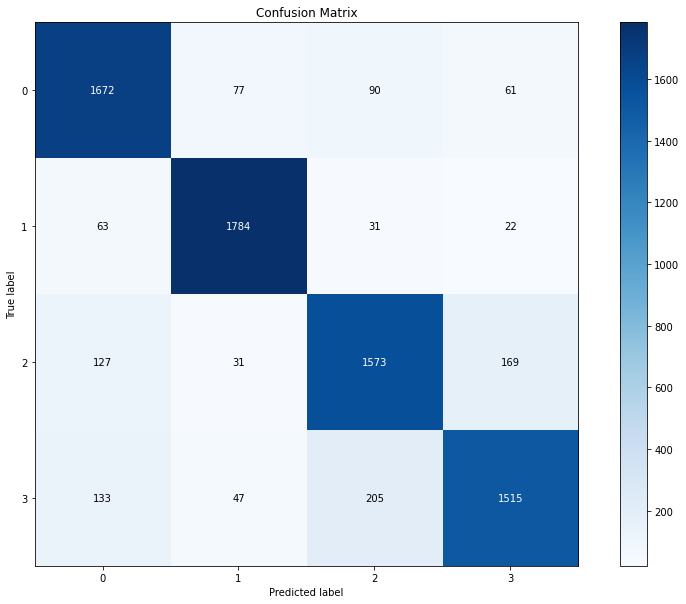

In [20]:
plot_confusion_matrix(targets, preds.argmax(axis=1), figsize=(15, 10))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


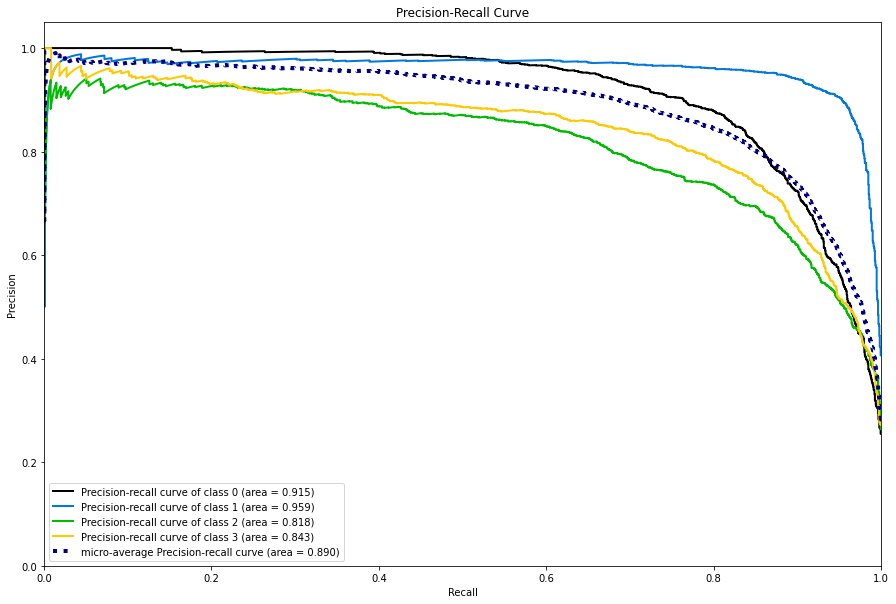

In [21]:
plot_precision_recall_curve(targets, preds, figsize=(15, 10))

# Inference

In [24]:
_, text = next(iter(test_dataset))

In [28]:
with torch.inference_mode():
  logits = model(
      torch.tensor(vocab(tokenizer(text))).to(device), torch.tensor([0]).to(device)
  )

In [29]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tec"}

In [35]:
score = F.softmax(logits, dim=1).max().detach().cpu().numpy().item() * 100
pred_label = ag_news_label[logits.argmax().detach().cpu().numpy().item()]

In [37]:
print('Text: {},\nLabel: {},\nScore: {}'.format(text, pred_label, score))

Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.,
Label: Sports,
Score: 94.12153363227844
